In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir, path
from time import time

In [2]:
DATASET = "dataset"
TRAINSET = "{0}/keras_png_slices_train".format(DATASET)
TESTSET = "{0}/keras_png_slices_test".format(DATASET)
BATCH_SIZE = 90
EPOCH = 1
NOISE_INPUT_DIM = 64

In [3]:
def train_set():
    train_dataset = []
    for i in listdir(TRAINSET):
        source = "{}/{}".format(TRAINSET, i)
        train_dataset.append(
            mpimg.imread(source)
        )
    return train_dataset

def test_set():
    test_dataset = []
    for i in listdir(TESTSET):
        source = "{}/{}".format(TESTSET, i)
        test_dataset.append(
            mpimg.imread(source)
        )
    return test_dataset

In [4]:
train_dataset = train_set()

In [9]:
maxvalue = 1
for m in range(1000):
    for i in range(256):
        for j in range(256):
            value = train_dataset[m][i][j]
            maxvalue = max(value, maxvalue)
print(maxvalue)

1.0


In [ ]:
test_dataset = test_set()

In [5]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [6]:
# Build the generator model
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(NOISE_INPUT_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.Reshape((4, 4, 256)))
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    
    
    model.add(layers.Conv2DTranspose(8, (5, 5), strides=(2,2 ), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    
    
    model.add(layers.Conv2DTranspose(16, (32, 32), strides=(8,8), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2DTranspose(1, (32, 32), strides=(4, 4), padding="same",activation="tanh"))
    return model
    

In [7]:
def generator_loss_func(output):
    return cross_entropy(tf.ones_like(output), output)

In [8]:
def generator_optimiser():
    return tf.keras.optimizers.Adam(1e-4)

In [9]:
# Build the discriminator model
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(5, 5), padding="same", input_shape=[256, 256, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5,5), strides=(5, 5), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, (5, 5), strides=(5, 5), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model.add(layers.Activation(tf.keras.activations.sigmoid))
    return model

In [10]:
def discriminator_loss_func(ro, fo):
    real_loss = cross_entropy(tf.ones_like(ro), ro)
    fake_loss = cross_entropy(tf.zeros_like(fo), fo)
    return real_loss + fake_loss

In [11]:
def discriminator_optimiser():
    return tf.keras.optimizers.Adam(1e-4)

In [12]:
generator = generator_model()

In [13]:
discriminator = discriminator_model()

In [14]:
generator_optmiser_func = generator_optimiser()
discriminator_optimiser_func = discriminator_optimiser()

In [15]:
@tf.function
def training(images):
    input_noise_set = tf.random.normal([BATCH_SIZE, NOISE_INPUT_DIM])
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        # Training the generator
        generated_image = generator(input_noise_set, training=True)
        output_real = discriminator(images, training=True)
        output_fake = discriminator(generated_image, training=True)
        # Get the loss of the generator and discriminator
        generator_current_loss = generator_loss_func(output_fake)
        # The discriminator loss involves both the real data and the fake noisy data 
        # This is so that discriminator would get better at identifying the noisy data
        # along with the real training data set
        discriminator_current_loss = discriminator_loss_func(output_real, output_fake)
    
    generator_gradient = generator_tape.gradient(generator_current_loss, generator.trainable_variables)
    discriminator_gradient = discriminator_tape.gradient(discriminator_current_loss, discriminator.trainable_variables)
    
    # Apply gradient optmised to both generator and discriminator
    generator_optmiser_func.apply_gradients(zip(generator_gradient, generator.trainable_variables))
    discriminator_optimiser_func.apply_gradients(zip(discriminator_gradient, discriminator.trainable_variables))

In [16]:
def train_model():
    for i in range(EPOCH):
        start_time = time()
        for idx in range(4500):
            image_dataset = train_dataset[idx]
            expanded_image_dataset = tf.expand_dims(image_dataset, axis=0)
            expanded_image_dataset = tf.expand_dims(expanded_image_dataset, axis=-1)
            training(expanded_image_dataset)
        if i % 5 == 0:
            # Every fifth epoch save the model
            generator.save("./generator")
            discriminator.save("./discriminator")
        print ("EPOCH iteration {} took {} seconds".format(i + 1, time() - start_time))
    generator.save("./generator")
    discriminator.save("./discriminator")

In [ ]:
with tf.device("/device:GPU:0"):
    train_model()

In [4]:
generator_model = tf.keras.models.load_model("./generator")
discriminator_model = tf.keras.models.load_model("./discriminator")


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f27686d4220> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f27686d4880>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f27686d4880> and <tensorflow.python.keras.layers.core.Reshape object at 0x7f27686a64f0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2DTranspose object at 0x7f27686a66d0> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f27686b0040>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f27686b0040> and <tensorflow.python.keras.layers.convolutional.Conv2DTranspose object at 0x7f27686b0d60>).

Two checkpoint references resolved to different obj


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Flatten object at 0x7f276833be20> and <tensorflow.python.keras.layers.core.Dropout object at 0x7f276833bbb0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f276833bee0> and <tensorflow.python.keras.layers.core.Flatten object at 0x7f276833be20>).


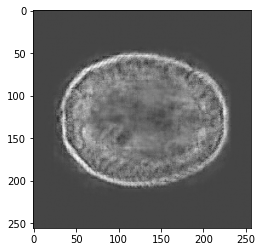

In [9]:
noise = tf.random.normal([1, NOISE_INPUT_DIM])
generated_image = generator_model(noise)[0]

plt.imshow(generated_image, cmap="gray")